In [1]:
!pip install Keras-Preprocessing

In [2]:
# import necessary libraries and packages
import pandas as pd
import numpy as np

import nltk, re, string
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /userhome/cs2/bg1999/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /userhome/cs2/bg1999/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /userhome/cs2/bg1999/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Data Preprocessing

In [3]:
from sklearn.model_selection import train_test_split

lemma = WordNetLemmatizer()
stop = stopwords.words('english')

# helper function to clean the sentence input to make it suitable for ML models
def Text_clean(txt):
    txt = txt.lower()
    words = nltk.word_tokenize(txt)
    words = ' '.join([lemma.lemmatize(word) for word in words if word not in stop])
    words_joined = "".join(words)
    text = re.sub('[^a-z]',' ',words_joined) #remove symbols 
    return text  

df_train = pd.read_csv("finbank_data_train.csv")
# apply Text_clean to the text column in the table, and create a new column "text_clean"
df_train['text_clean'] = df_train['text'].apply(Text_clean)
sentences_train = df_train['text_clean'].values
y_train = df_train['label'].values

df_test = pd.read_csv("finbank_data_test.csv")
# apply Text_clean to the text column in the table, and create a new column "text_clean"
df_test['text_clean'] = df_test['text'].apply(Text_clean)
sentences_test = df_test['text_clean'].values
y_test = df_test['label'].values

df_val = pd.read_csv("finbank_data_val.csv")
# apply Text_clean to the text column in the table, and create a new column "text_clean"
df_val['text_clean'] = df_val['text'].apply(Text_clean)
sentences_val = df_val['text_clean'].values
y_val = df_val['label'].values

In [4]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# helper function for plotting history of the model training process
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)
X_val=tokenizer.texts_to_sequences(sentences_val)
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit([['neutral'],['positive'],['negative']])

# transform Label of Train set to One Hot Encoding
temp=[]
for i in y_train:
    if i=='neutral':
        temp.append([0,1,0])
    if i=='positive':
        temp.append([1,0,0])
    if i=='negative':
        temp.append([0,0,1])
y_train=np.array(temp)
print(y_train)

# transform Label of Test set to One Hot Encoding
temp=[]
for i in y_test:
    if i=='neutral':
        temp.append([0,1,0])
    if i=='positive':
        temp.append([1,0,0])
    if i=='negative':
        temp.append([0,0,1])
y_test=np.array(temp)

# transform Label of Validation set to One Hot Encoding
temp=[]
for i in y_val:
    if i=='neutral':
        temp.append([0,1,0])
    if i=='positive':
        temp.append([1,0,0])
    if i=='negative':
        temp.append([0,0,1])
y_val=np.array(temp)


from keras_preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_val=pad_sequences(X_val, padding='post', maxlen=maxlen)
print(X_train)

2023-04-01 19:23:41.851964: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[[1 0 0]
 [0 0 1]
 [0 1 0]
 ...
 [0 1 0]
 [1 0 0]
 [0 1 0]]
[[  82  604  391 ...    0    0    0]
 [   9  360  723 ...    0    0    0]
 [  52 3809 2131 ...    0    0    0]
 ...
 [  31  301    6 ...    0    0    0]
 [ 268 2215  641 ...    0    0    0]
 [ 332 3620 3621 ...    0    0    0]]


# LSTM Model

In [16]:
from keras.models import Sequential
from keras import layers
from keras.backend import clear_session

clear_session()
embedding_dim = 50

# create model
model = Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
    layers.SpatialDropout1D(0.4),
    layers.Bidirectional(layers.LSTM(176, dropout=0.2, recurrent_dropout=0.2)),
    layers.Dense(24, activation='relu'),
    layers.Dense(3, activation='softmax')
])

# compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           290500    
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 50)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 352)              319616    
 l)                                                              
                                                                 
 dense (Dense)               (None, 24)                8472      
                                                                 
 dense_1 (Dense)             (None, 3)                 75        
                                                                 
Total params: 618,663
Trainable params: 618,663
Non-trai

In [17]:
epochs = 10
batch_size = 64

# train the LSTM model
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    verbose=True,
                    validation_data=(X_val, y_val),
                    batch_size=batch_size)

Epoch 1/10
74/74 [==============================] - 75s 916ms/step - loss: 0.9875 - accuracy: 0.4680 - val_loss: 0.8552 - val_accuracy: 0.5702
Epoch 2/10
74/74 [==============================] - 62s 842ms/step - loss: 0.7272 - accuracy: 0.6615 - val_loss: 0.7172 - val_accuracy: 0.6969
Epoch 3/10
74/74 [==============================] - 63s 849ms/step - loss: 0.4974 - accuracy: 0.8016 - val_loss: 0.6142 - val_accuracy: 0.7654
Epoch 4/10
74/74 [==============================] - 61s 822ms/step - loss: 0.3646 - accuracy: 0.8735 - val_loss: 0.5758 - val_accuracy: 0.8014
Epoch 5/10
74/74 [==============================] - 60s 816ms/step - loss: 0.2761 - accuracy: 0.9039 - val_loss: 0.6020 - val_accuracy: 0.8151
Epoch 6/10
74/74 [==============================] - 60s 813ms/step - loss: 0.2337 - accuracy: 0.9234 - val_loss: 0.7658 - val_accuracy: 0.7877
Epoch 7/10
74/74 [==============================] - 59s 800ms/step - loss: 0.2138 - accuracy: 0.9255 - val_loss: 0.5776 - val_accuracy: 0.8305

Training Accuracy: 0.9788
Testing Accuracy:  0.8493


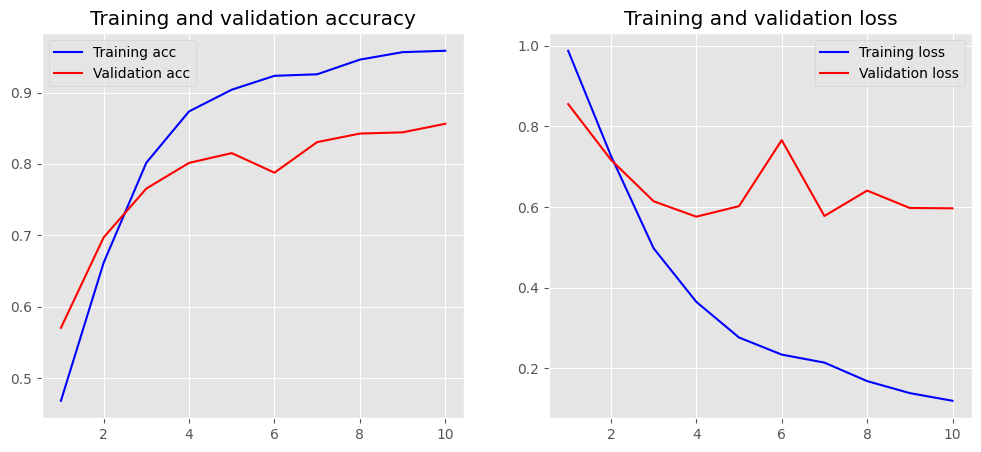

In [18]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

# Hyperparameters Tuning

We use grid search to find the optimal hyperparameters for our LSTM model.

In [6]:
!pip install scikeras

In [11]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from keras.models import Sequential
from keras import layers

def get_model():
  return Sequential([
      layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
      layers.SpatialDropout1D(0.4),
      layers.Bidirectional(layers.LSTM(176, dropout=0.2, recurrent_dropout=0.2)),
      layers.Dense(24, activation='relu'),
      layers.Dense(3, activation='softmax')
  ])

def get_model_gs_neurons(neurons):
  return Sequential([
      layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
      layers.SpatialDropout1D(0.4),
      layers.Bidirectional(layers.LSTM(176, dropout=0.2, recurrent_dropout=0.2)),
      layers.Dense(neurons, activation='relu'),
      layers.Dense(3, activation='softmax')
  ])

def get_model_gs_units(units):
  return Sequential([
      layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
      layers.SpatialDropout1D(0.4),
      layers.Bidirectional(layers.LSTM(units, dropout=0.2, recurrent_dropout=0.2)),
      layers.Dense(24, activation='relu'),
      layers.Dense(3, activation='softmax')
  ])

In [12]:
# helper function to summarize results
def print_gridsearch_results(grid_result):
  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  means = grid_result.cv_results_['mean_test_score']
  stds = grid_result.cv_results_['std_test_score']
  params = grid_result.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
      print("%f (%f) with: %r" % (mean, stdev, param))

Hyperparameter: Epochs, Batch Size

In [13]:
model = KerasClassifier(model=get_model, loss="categorical_crossentropy", verbose=True)

# define the grid search parameters
batch_size = [32, 64]
epochs = [5, 7, 10]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)
grid_result = grid.fit(X_train, y_train)

# summarize results
print_gridsearch_results(grid_result)

Epoch 1/5


2023-03-29 13:49:30.425916: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x203b9fb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-29 13:49:30.425977: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-03-29 13:49:30.435718: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-29 13:49:30.546286: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-29 13:49:30.680402: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


73/73 [==============================] - 44s 501ms/step - loss: 1.0696
Epoch 2/5
73/73 [==============================] - 33s 450ms/step - loss: 0.9078
Epoch 3/5
73/73 [==============================] - 30s 406ms/step - loss: 0.7978
Epoch 4/5
73/73 [==============================] - 31s 422ms/step - loss: 0.6965
Epoch 5/5
74/74 [==============================] - 6s 72ms/step
Epoch 1/5
74/74 [==============================] - 68s 843ms/step - loss: 1.0821
Epoch 2/5
74/74 [==============================] - 60s 805ms/step - loss: 0.9306
Epoch 3/5
74/74 [==============================] - 58s 785ms/step - loss: 0.7948
Epoch 4/5
74/74 [==============================] - 58s 778ms/step - loss: 0.6466
Epoch 5/5
73/73 [==============================] - 6s 76ms/step
Epoch 1/7
73/73 [==============================] - 36s 441ms/step - loss: 1.0789
Epoch 2/7
73/73 [==============================] - 31s 429ms/step - loss: 0.9323
Epoch 3/7
73/73 [==============================] - 30s 414ms/step - loss

Hyperparameter: Optimizer

In [14]:
model = KerasClassifier(model=get_model, loss="categorical_crossentropy", epochs=10, batch_size=64, verbose=True)

# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)
grid_result = grid.fit(X_train, y_train)

# summarize results
print_gridsearch_results(grid_result)

Epoch 1/10
37/37 [==============================] - 42s 918ms/step - loss: 1.0979
Epoch 2/10
37/37 [==============================] - 32s 876ms/step - loss: 1.0978
Epoch 3/10
37/37 [==============================] - 32s 851ms/step - loss: 1.0975
Epoch 4/10
37/37 [==============================] - 31s 838ms/step - loss: 1.0971
Epoch 5/10
37/37 [==============================] - 30s 818ms/step - loss: 1.0972
Epoch 6/10
37/37 [==============================] - 31s 845ms/step - loss: 1.0971
Epoch 7/10
37/37 [==============================] - 31s 823ms/step - loss: 1.0971
Epoch 8/10
37/37 [==============================] - 31s 843ms/step - loss: 1.0970
Epoch 9/10
37/37 [==============================] - 29s 791ms/step - loss: 1.0968
Epoch 10/10
37/37 [==============================] - 3s 77ms/step
Epoch 1/10
37/37 [==============================] - 37s 858ms/step - loss: 1.0988
Epoch 2/10
37/37 [==============================] - 31s 845ms/step - loss: 1.0984
Epoch 3/10
37/37 [==============

Hyperparameter: Learning Rate, Momentum

Hyperparameter: Number of neurons in Dense layer

In [12]:
model = KerasClassifier(model=get_model_gs_neurons, loss="categorical_crossentropy", optimizer="adam", epochs=10, batch_size=64, verbose=True)

# define the grid search parameters
neurons = [10, 25, 40]
param_grid = dict(model__neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)
grid_result = grid.fit(X_train, y_train)

# summarize results
print_gridsearch_results(grid_result)

Epoch 1/10


2023-03-28 15:15:39.584366: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x204a9d70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-28 15:15:39.584436: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-03-28 15:15:39.595547: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-28 15:15:39.715462: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-28 15:15:39.816760: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


59/59 [==============================] - 67s 972ms/step - loss: 1.0712
Epoch 2/10
59/59 [==============================] - 53s 905ms/step - loss: 1.0018
Epoch 3/10
59/59 [==============================] - 52s 886ms/step - loss: 1.0227
Epoch 4/10
59/59 [==============================] - 49s 828ms/step - loss: 0.7487
Epoch 5/10
59/59 [==============================] - 50s 842ms/step - loss: 0.6496
Epoch 6/10
59/59 [==============================] - 49s 831ms/step - loss: 0.5536
Epoch 7/10
59/59 [==============================] - 48s 817ms/step - loss: 0.4612
Epoch 8/10
59/59 [==============================] - 48s 822ms/step - loss: 0.3614
Epoch 9/10
59/59 [==============================] - 47s 804ms/step - loss: 0.2941
Epoch 10/10
15/15 [==============================] - 2s 71ms/step
Epoch 1/10
59/59 [==============================] - 59s 889ms/step - loss: 1.0562
Epoch 2/10
59/59 [==============================] - 51s 865ms/step - loss: 0.7828
Epoch 3/10
59/59 [=========================

Hyperparameter: Number of units in LSTM layer

In [15]:
model = KerasClassifier(model=get_model_gs_units, loss="categorical_crossentropy", optimizer="adam", epochs=10, batch_size=64, verbose=True)

# define the grid search parameters
units = [150, 175, 200]
param_grid = dict(model__units=units)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)
grid_result = grid.fit(X_train, y_train)

# summarize results
print_gridsearch_results(grid_result)

Epoch 1/10
37/37 [==============================] - 65s 940ms/step - loss: 1.0763
Epoch 2/10
37/37 [==============================] - 34s 919ms/step - loss: 0.8841
Epoch 3/10
37/37 [==============================] - 34s 909ms/step - loss: 0.6647
Epoch 4/10
37/37 [==============================] - 34s 927ms/step - loss: 0.4807
Epoch 5/10
37/37 [==============================] - 34s 922ms/step - loss: 0.3697
Epoch 6/10
37/37 [==============================] - 30s 821ms/step - loss: 0.2892
Epoch 7/10
37/37 [==============================] - 33s 885ms/step - loss: 0.2277
Epoch 8/10
37/37 [==============================] - 32s 867ms/step - loss: 0.1737
Epoch 9/10
37/37 [==============================] - 32s 861ms/step - loss: 0.1400
Epoch 10/10
37/37 [==============================] - 3s 77ms/step
Epoch 1/10
37/37 [==============================] - 41s 939ms/step - loss: 1.0759
Epoch 2/10
37/37 [==============================] - 33s 894ms/step - loss: 0.8425
Epoch 3/10
37/37 [==============

# Best LSTM Model

In [6]:
from keras.models import Sequential
from keras import layers
from keras.backend import clear_session

clear_session()
embedding_dim = 50

# create model
model = Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
    layers.SpatialDropout1D(0.4),
    layers.Bidirectional(layers.LSTM(200, dropout=0.25, recurrent_dropout=0.25)),
    layers.Dense(40, activation='relu'),
    layers.Dense(3, activation='softmax')
])

# compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

2023-04-01 19:24:26.162594: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-01 19:24:26.204751: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-01 19:24:26.205904: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-01 19:24:26.207770: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           290500    
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 50)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 400)              401600    
 l)                                                              
                                                                 
 dense (Dense)               (None, 40)                16040     
                                                                 
 dense_1 (Dense)             (None, 3)                 123       
                                                                 
Total params: 708,263
Trainable params: 708,263
Non-trai

In [7]:
epochs = 10
batch_size = 32

# train the LSTM model
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    verbose=True,
                    validation_data=(X_val, y_val),
                    batch_size=batch_size)

Epoch 1/10


2023-04-01 19:24:57.790361: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1e182190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-01 19:24:57.790441: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-04-01 19:24:57.800262: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-01 19:24:57.938227: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-01 19:24:58.076914: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


147/147 [==============================] - 149s 942ms/step - loss: 0.9553 - accuracy: 0.5080 - val_loss: 0.7845 - val_accuracy: 0.6524
Epoch 2/10
147/147 [==============================] - 129s 878ms/step - loss: 0.5672 - accuracy: 0.7614 - val_loss: 0.4933 - val_accuracy: 0.8390
Epoch 3/10
147/147 [==============================] - 123s 835ms/step - loss: 0.3092 - accuracy: 0.8894 - val_loss: 0.3949 - val_accuracy: 0.8733
Epoch 4/10
147/147 [==============================] - 122s 831ms/step - loss: 0.2046 - accuracy: 0.9257 - val_loss: 0.3895 - val_accuracy: 0.8870
Epoch 5/10
147/147 [==============================] - 122s 832ms/step - loss: 0.1559 - accuracy: 0.9448 - val_loss: 0.4067 - val_accuracy: 0.8904
Epoch 6/10
147/147 [==============================] - 122s 831ms/step - loss: 0.1438 - accuracy: 0.9465 - val_loss: 0.4231 - val_accuracy: 0.8853
Epoch 7/10
147/147 [==============================] - 121s 820ms/step - loss: 0.1042 - accuracy: 0.9638 - val_loss: 0.4603 - val_accura

Training Accuracy: 0.9872
Testing Accuracy:  0.8836


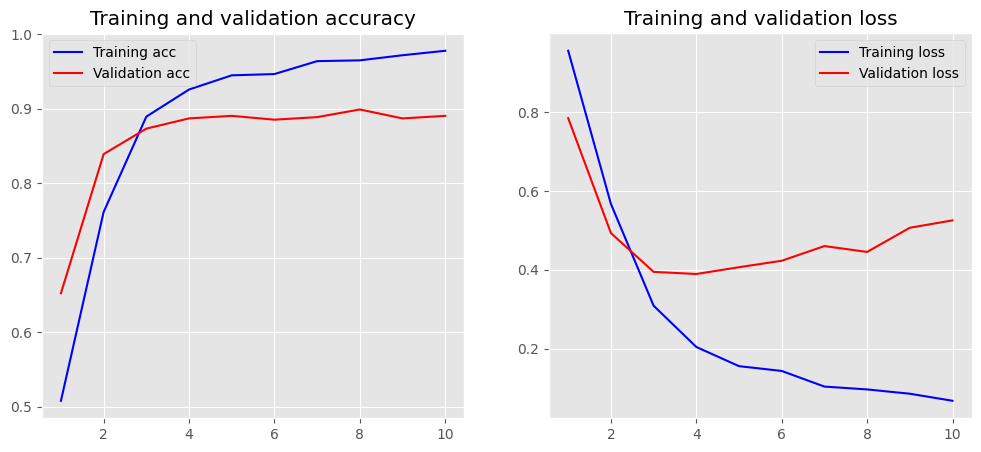

In [8]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [22]:
df_news_Earnings = pd.read_csv("news_Earnings.csv")
df_news_Economic = pd.read_csv("news_Economic.csv")
df_news_StockMarket = pd.read_csv("news_StockMarket.csv")

df_news_Earnings['text_clean'] = df_news_Earnings['text'].apply(Text_clean)
df_news_Economic['text_clean'] = df_news_Economic['text'].apply(Text_clean)
df_news_StockMarket['text_clean'] = df_news_StockMarket['text'].apply(Text_clean)

df_news_Earnings_sentences = df_news_Earnings['text_clean'].values
df_news_Economic_sentences = df_news_Economic['text_clean'].values
df_news_StockMarket_sentences = df_news_StockMarket['text_clean'].values

X_news_Earnings = tokenizer.texts_to_sequences(df_news_Earnings_sentences)
X_news_Economic = tokenizer.texts_to_sequences(df_news_Economic_sentences)
X_news_StockMarket = tokenizer.texts_to_sequences(df_news_StockMarket_sentences)

X_news_Earnings = pad_sequences(X_news_Earnings, padding='post', maxlen=maxlen)
X_news_Economic = pad_sequences(X_news_Economic, padding='post', maxlen=maxlen)
X_news_StockMarket = pad_sequences(X_news_StockMarket, padding='post', maxlen=maxlen)

y_news_Earnings = model.predict(X_news_Earnings)
y_news_Economic = model.predict(X_news_Economic)
y_news_StockMarket = model.predict(X_news_StockMarket)

1/1 [==============================] - 0s 98ms/step


In [23]:
y_news_Earnings

array([[2.7880684e-04, 9.9970299e-01, 1.8282706e-05],
       [5.5091325e-03, 9.9300426e-01, 1.4865270e-03],
       [5.7423417e-03, 9.8350084e-01, 1.0756843e-02],
       [2.5296855e-01, 1.8359499e-01, 5.6343651e-01],
       [1.8849215e-02, 6.4667630e-01, 3.3447447e-01],
       [2.5260901e-02, 1.2201483e-03, 9.7351891e-01],
       [1.1792505e-01, 7.4945039e-01, 1.3262451e-01],
       [9.0452231e-02, 6.7376745e-01, 2.3578028e-01],
       [1.4468300e-01, 1.0643622e-02, 8.4467334e-01],
       [6.8221940e-03, 2.8808746e-02, 9.6436912e-01]], dtype=float32)

In [24]:
y_news_Economic

array([[9.8819230e-03, 2.4639456e-02, 9.6547860e-01],
       [7.7784801e-04, 9.9759382e-01, 1.6282895e-03],
       [8.0343550e-03, 3.2639957e-03, 9.8870158e-01],
       [7.2555584e-03, 9.9256986e-01, 1.7448606e-04],
       [3.4282368e-04, 9.9949098e-01, 1.6624940e-04],
       [4.6691094e-03, 9.7776324e-01, 1.7567733e-02],
       [3.8970897e-01, 1.4477353e-02, 5.9581375e-01],
       [1.0275117e-02, 4.8012198e-03, 9.8492372e-01],
       [4.9022463e-01, 1.8996908e-01, 3.1980628e-01],
       [8.4946382e-01, 5.4309860e-02, 9.6226335e-02]], dtype=float32)

In [25]:
y_news_StockMarket

array([[6.2640166e-01, 2.8716975e-01, 8.6428620e-02],
       [2.6850122e-01, 1.2534329e-01, 6.0615551e-01],
       [7.2312713e-02, 9.2521572e-01, 2.4715830e-03],
       [2.4950902e-01, 3.1995252e-02, 7.1849573e-01],
       [7.4887620e-03, 9.9166334e-01, 8.4793469e-04],
       [1.9873658e-02, 9.6594530e-01, 1.4180971e-02],
       [2.2054419e-02, 8.2624513e-01, 1.5170042e-01],
       [1.5487850e-03, 9.9702317e-01, 1.4280579e-03],
       [3.4412104e-04, 9.9924052e-01, 4.1531472e-04],
       [1.9793961e-02, 9.7883987e-01, 1.3661659e-03]], dtype=float32)

In [26]:
# convert softmax output to labels
temp=[]
for i in y_news_Earnings:
    temp.append(np.argmax(i))
y_news_Earnings=np.array(temp)

# convert softmax output to labels
temp=[]
for i in y_news_Economic:
    temp.append(np.argmax(i))
y_news_Economic=np.array(temp)

# convert softmax output to labels
temp=[]
for i in y_news_StockMarket:
    temp.append(np.argmax(i))
y_news_StockMarket=np.array(temp)

In [27]:
print(y_news_Earnings)
print(y_news_Economic)
print(y_news_StockMarket)

[1 1 1 2 1 2 1 1 2 2]
[2 1 2 1 1 1 2 2 0 0]
[0 2 1 2 1 1 1 1 1 1]


In [28]:
df_news_Earnings['test_result'] = y_news_Earnings
df_news_Economic['test_result'] = y_news_Economic
df_news_StockMarket['test_result'] = y_news_StockMarket

In [32]:
# 'positive' = [1,0,0] = 0
# 'neutral' = [0,1,0] = 1
# 'negative' = [0,0,1] = 2

In [29]:
df_news_Economic

,text,label,text_clean,test_result
0,Tokyo Inflation Slows Ahead of BOJ Leadership ...,positive,tokyo inflation slows ahead boj leadership cha...,1
1,Fed Watchdog Launches Investigation Into SVB S...,neutral,fed watchdog launch investigation svb supervision,1
2,Fed Officials See More Work on Inflation Despi...,neutral,fed official see work inflation despite bank s...,1
3,Colombia Hikes Interest Rate to 24-Year High t...,neutral,colombia hike interest rate year high tame ...,2
4,"Australian Inflation Eases, Bolstering Case fo...",positive,australian inflation eas bolstering case rat...,1
5,Goldman Sachs says the banking meltdown is a ‘...,positive,goldman sachs say banking meltdown headwind ...,2
6,Banking crisis has ‘definitely’ tipped the U.S...,negative,banking crisis definitely tipped u s clos...,1
7,Existing home sales jump in February as mortga...,positive,existing home sale jump february mortgage rate...,1
8,Top economist Mohamed El-Erian warns that ‘ero...,negative,top economist mohamed el erian warns erosion...,2
9,Labor market: Workers are getting two jobs ami...,negative,labor market worker getting two job amid inf...,2


In [30]:
df_news_Earnings

,text,label,text_clean,test_result
0,Homebuilder Lennar sees 'no disruption' in len...,positive,homebuilder lennar see no disruption lendin...,2
1,Media giants signal ad market 'stabilized' aft...,positive,medium giant signal ad market stabilized br...,1
2,Costco Q2 earnings: Stock slips after mixed re...,neutral,costco q earnings stock slip mixed result,2
3,"Salesforce earnings: Company reports beats, st...",positive,salesforce earnings company report beat st...,1
4,"Salesforce's activist investors: Who are they,...",neutral,salesforce s activist investor want,1
5,J.M. Smucker CEO: PB&J is our 'bread & butter'...,positive,j m smucker ceo pb j bread butter ...,1
6,HP earnings: Sales decline ‘driven by the macr...,negative,hp earnings sale decline driven macroecono...,2
7,"Warner Bros. Discovery sinks on earnings miss,...",negative,warner bros discovery sink earnings miss we...,2
8,Lucid earnings: Stock slides as EV-maker misse...,negative,lucid earnings stock slide ev maker miss rev...,0
9,Shake Shack earnings come mostly in line with ...,neutral,shake shack earnings come mostly line estimate,0


In [31]:
df_news_StockMarket

,text,label,text_clean,test_result
0,Zoetis Stock Could Rise 30% as People Spend Mo...,positive,zoetis stock could rise people spend pet,0
1,Dow Jones Rallies 250 Points; Lululemon Soars ...,positive,dow jones rally point lululemon soar ...,2
2,"U.S. Stocks Open Higher, Following Internation...",positive,u s stock open higher following internation...,1
3,Bank Crisis Credit Crunch Will Clip S&P 500 Ea...,negative,bank crisis credit crunch clip p earning...,2
4,Micron Stock Jumps Despite Sales Plunging 53%....,neutral,micron stock jump despite sale plunging ...,1
5,Deere Is Sowing the Seeds of Success. Why the ...,positive,deere sowing seed success stock ride economi...,1
6,TikTok parent ByteDance has special stock owne...,neutral,tiktok parent bytedance special stock owned ch...,1
7,These Stocks Are Moving the Most Today: Micron...,neutral,stock moving today micron lululemon alib...,1
8,Wall Street's sharks are circling 'dumb and gr...,negative,wall street s shark circling dumb greedy b...,1
9,Climate Funding Gets Squeezed by Volatile Markets,negative,climate funding get squeezed volatile market,1
